In [1]:
import time

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# fix the random seed; don't modify this
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(23459078)
if torch.cuda.is_available():
    torch.cuda.manual_seed(23459078)

In [2]:
moonboard_data = np.load('board_grade.npy', allow_pickle=True)

x, y = moonboard_data[:, 1], moonboard_data[:, 0]

# make sure labels are correct
for i in range(y.shape[0]):
    try:
        assert y[i].shape == y[i+1].shape
    except:
        if i + 1 < y.shape[0]:
            print(y[i+1])

all_boards = np.stack(x).reshape(-1, 18, 11, 2)
all_classes = np.stack(y).reshape(-1, 7)

all_boards.shape

(19819, 18, 11, 2)

In [3]:
grade_to_list = {
    "V4 (6B+)": tuple([0,0,0,0,0,0,0]),
    "V5 (6C/+)": tuple([1,0,0,0,0,0,0]),
    "V6 (7A)": tuple([1,1,0,0,0,0,0]),
    "V7 (7A+)": tuple([1,1,1,0,0,0,0]),
    "V8 (7B/+)": tuple([1,1,1,1,0,0,0]),
    "V9 (7C)": tuple([1,1,1,1,1,0,0]),
    "V10 (7C+)": tuple([1,1,1,1,1,1,0]),
    "V11 (8A) or harder": tuple([1,1,1,1,1,1,1]),
}

grade_num_to_list = {
    0: tuple([0,0,0,0,0,0,0]),
    1: tuple([1,0,0,0,0,0,0]),
    2: tuple([1,1,0,0,0,0,0]),
    3: tuple([1,1,1,0,0,0,0]),
    4: tuple([1,1,1,1,0,0,0]),
    5: tuple([1,1,1,1,1,0,0]),
    6: tuple([1,1,1,1,1,1,0]),
    7: tuple([1,1,1,1,1,1,1]),
}

print_dict = {
    0: "M",
    1: "S",
    2: "E"
}

list_to_grade = dict((v,k) for k,v in grade_to_list.items())
list_to_grade_num = dict((v,k) for k,v in grade_num_to_list.items())

def print_board_bar():
    for i in range(26):
        print("-", end="")
    print()

def print_board(board, grade_list):
    print(" "*3, end="| ")
    for i in range(11):
        print(f"{chr(i + 65)}", end=" ")
    print()
    print_board_bar()
    for i in range(18):
        print(f"{18 - i:2} |", end=" ")
        for j in range(11):
            num_printed = False
            if board[17 - i, j, 0] > 0:
                char = "M"
                if board[17 - i, j, 1] > 0:
                    char = "S" if i >= 12 else "E"
                print(char, end=" ")  
                num_printed = True
            if not num_printed:
                print("-", end=" ")
        print()
    print_board_bar()
        
    print(f"Problem Grade: {list_to_grade[tuple([round(x) for x in grade_list])]}")

def print_problem(problem_num):
    if problem_num < 0 or problem_num > all_boards.shape[0]:
        print("problem number out of bounds!")
        return -1
    print_board(all_boards[problem_num], all_classes[problem_num])

print_problem(1)
print()
print()
print_problem(5)
print()
print()
print_problem(10)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - E - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - M - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - M - M 
10 | - - - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - M - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)


   | A B C D E F G H I J K 
--------------------------
18 | - - E - - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - M - - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - M - - - - - - - 
12 | - - - - - - - - M - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - M - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - 

In [4]:
# Convert data to PyTorch tensors
x_tensor = torch.tensor(all_boards, dtype=torch.float32)
y_tensor = torch.tensor(all_classes, dtype=torch.float32)

# create the dataset
dataset = data.TensorDataset(x_tensor, y_tensor)

# do stratified random sampling to split our data. we stratify because of our large imbalance, as without stratification, our validation and test sets
# may not be fully representative of the class balance of the real world data, and we may miss out entirely on having some classes in our valid / test split

# Define the sizes for train/validation/test splits. We use a 60/20/20 split, as 80/10/10 may be too little of a test and valid set given class imbalance
train_size = 0.6
val_size = 0.2

# Generate indices for train/validation/test splits
train_indices, temp_indices, _, _ = train_test_split(
    range(len(dataset)),
    y_tensor,
    stratify=y_tensor,
    test_size=(1 - train_size),
    random_state=42
)

# Further split the temp set into validation and test sets
val_indices, test_indices, _, _ = train_test_split(
    temp_indices,
    [y_tensor[i] for i in temp_indices],  # Use y_tensor for stratification
    stratify=[y_tensor[i] for i in temp_indices],
    test_size=(val_size / (1 - train_size)),  # Calculate test size relative to the temp set
    random_state=42
)

# generate subset based on indices
train_dataset = data.Subset(dataset, train_indices)
val_dataset = data.Subset(dataset, val_indices)
test_dataset = data.Subset(dataset, test_indices)

#train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

In [5]:
# create an oversampler
# Define a function to calculate class weights
def calculate_class_weights(dataset, num_classes):
    class_counts = [0] * num_classes

    # Count occurrences of each class in the dataset
    for sample in dataset:
        label = max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])])
        class_counts[label] += 1

    # Calculate normalized class weights
    class_weights = [1 / (count) for count in class_counts]
    weights_total = sum(class_weights)
    class_weights_normalized = [weight / weights_total for weight in class_weights]

    return class_weights_normalized

# Calculate sample weights from class weights
class_weights = calculate_class_weights(train_dataset, 8)
labels = [max([i+1 if x > 0 else 0 for i, x in enumerate(sample[1])]) for sample in train_dataset]
sample_weights = [class_weights[label] for label in labels]

# Create upsampler using sample weights
train_sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=len(train_dataset), replacement=True)

print("Class weights:", class_weights)

Class weights: [0.010585902638876623, 0.015534637520010273, 0.0340073942408478, 0.05914683161027835, 0.04430712475465296, 0.18313611565256557, 0.19544170445135453, 0.4578402891314139]


In [6]:
INPUT_DIM = 18 * 11 * 2
OUTPUT_DIM = 7

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# calculate the number of exactly correct predictions
def calculate_accuracy(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (torch.sum(thresh_y[i]) == torch.sum(thresh_pred[i]))
    acc = correct.float() / y.shape[0]
    return acc

# calculate the number of correct predictions within one class
def calculate_plus_minus_one(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (torch.abs(torch.sum(thresh_y[i]) - torch.sum(thresh_pred[i])) <= 1)
    acc = correct.float() / y.shape[0]
    return acc

In [7]:
# custom weight sharing final layer for ordinal regression, in the style of CORAL (1 weight, K - 1 bias)
# doing it this way, along with the way classes are set up (a binary classification with K - 1 classes) assures rank constisency and improves performance.
# However, it limits the predictive power of the models due to the weight sharing at the output, and as such CORN loss would be a reasonable next step
class CoralLayer(torch.nn.Module):
    def __init__(self, size_in, num_classes):
        super().__init__()
        self.size_in, self.size_out = size_in, 1
        self.coral_weight = torch.nn.Linear(self.size_in, 1, bias=False)
        self.coral_bias = torch.nn.Parameter(torch.arange(num_classes, 0, -1).float() / (num_classes))

    def forward(self, x):
        return self.coral_weight(x) + self.coral_bias

In [8]:
# a small MLP, to get a baseline for likely performance
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 64)
        self.hidden_fc = nn.Linear(64, 32)
        self.hidden_fc2 = nn.Linear(32, 16)
        self.output_fc = CoralLayer(16, output_dim)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = self.dropout(F.mish(self.input_fc(x)))
        h_2 = self.dropout(F.mish(self.hidden_fc(h_1)))
        h_3 = self.dropout(F.mish(self.hidden_fc2(h_2)))
        y_pred = self.output_fc(h_3)
        return y_pred, h_3

In [9]:
# A CNN, where we use regularization and a small effective model to exploit spatial properties in the data
class CNN(nn.Module):
    def __init__(self, input_channels, input_size, output_dim):
        super().__init__()

        self.input_conv2d = nn.Conv2d(input_channels, 16, 11, padding=5)
        self.pool = nn.AdaptiveMaxPool2d(11)
        self.flatten = nn.Flatten()
        self.hidden_fc = nn.Linear(16 * 11 * 11, 64)
        self.hidden_fc2 = nn.Linear(64, 16)
        self.output_fc = CoralLayer(16, output_dim)

        self.dropoutConv = nn.Dropout2d(0.5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        batch_size = x.shape[0]
        # use BCHW form instead of BHWC form for Conv layers
        x = x.permute(0, 3, 1, 2)
        c_1 = self.dropoutConv(F.mish(self.input_conv2d(x)))
        h_pool = self.flatten(self.pool(c_1))
        h_1 = self.dropout(F.mish(self.hidden_fc(h_pool)))
        h_2 = F.mish(self.hidden_fc2(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred, h_2

n_channels = 2

In [10]:
# a deeper residual CNN (ResNet style), where we use a deep network with skip connections to build a more abstract feature set and gain predictive power
class ResidualBlock(nn.Module):
    
    def __init__(self, in_size, hidden_size, out_size, kernel_size, use_pooling = True):
        super().__init__()
        conv_pad = (kernel_size) // 2 # calculate the proper padding for a given kernel size
        self.conv1 = nn.Conv2d(in_size, hidden_size, kernel_size, padding=conv_pad)
        self.conv2 = nn.Conv2d(hidden_size, out_size, kernel_size, padding=conv_pad)
        self.maxpool = nn.MaxPool2d(kernel_size, stride=1, padding=conv_pad)
        
        self.dropoutConv = nn.Dropout2d(0.5)
        self.use_pooling = use_pooling
    
    def ConvBlock(self, x):
        c_1 = self.dropoutConv(F.mish(self.conv1(x)))
        c_2 = self.dropoutConv(F.mish(self.conv2(c_1)))
        if self.use_pooling:
            d_1 = self.maxpool(c_2)
            return d_1
        return c_2
    
    def forward(self, x):
        return x + self.ConvBlock(x)


class ResNet(nn.Module):
    
    def __init__(self, input_channels, input_size, output_dim):
        super().__init__()
        self.input_conv2d = nn.Conv2d(input_channels, 16, 11, padding=5)
        self.res_block1 = ResidualBlock(16, 32, 16, 7, False)
        self.res_block2 = ResidualBlock(16, 32, 16, 5, True) # after our first two blocks we add a pooling layer
        self.res_block3 = ResidualBlock(16, 32, 16, 3, False)
        self.pool = nn.AdaptiveMaxPool2d(11)
        self.flatten = nn.Flatten()
        self.hidden_fc = nn.Linear(16 * 11 * 11, 32)
        self.output_fc = CoralLayer(32, output_dim)
        
    def forward(self, x):
        batch_size = x.shape[0]
        # use BCHW form instead of BHWC form for Conv layers
        x = x.permute(0, 3, 1, 2)
        # input
        conv = F.mish(self.input_conv2d(x))
        # resnet blocks
        b_1 = self.res_block1(conv)
        b_2 = self.res_block2(b_1)
        b_3 = self.res_block3(b_2)
        h_pool = self.flatten(self.pool(b_3))
        # fully connected
        h_1 = F.mish(self.hidden_fc(h_pool))
        y_pred = self.output_fc(h_1)
        return y_pred, h_1

n_channels = 2

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(INPUT_DIM, OUTPUT_DIM)
BATCH_SIZE = 8

train_iterator = data.DataLoader(train_dataset,
                                 #shuffle=True,
                                 sampler=train_sampler,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_dataset,
                                 batch_size=BATCH_SIZE)

# Loss and optimizer
avg_class_difficulty = torch.tensor([1, 1, 1.1, 1.2, 1.25, 1.25, 2]) # these weights correspond to the relative avg class difficulty (to classify)
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device)
criterion = criterion.to(device)

# label smoothing since our label dataset is somewhat noisy (due to the subjectiveness of grades and the culture of the moonboard)
# an ordinal-aware version of label smoothing, original afaik
# we smooth the ordinal boundary more than the other classes (e.g. [1, 1, 1, 1, 0, 0, 0] -> [0.995, 0.995, 0.995, 0.975, 0.025, 0.005, 0.005])
def label_smoothing_ordinal_aware(labels, eps = 5e-2, num_classes = 8):
    smoothed_labels = labels * (1 - (eps / (num_classes - 2))) + eps / (num_classes - 1) # canonical label smoothing equation
    for label_idx, label in enumerate(labels): # boundary based adjustment
        label_class = int(torch.sum(label).item())
        if label_class == 0:
            smoothed_labels[label_idx, label_class] = eps / 2
        elif label_class < num_classes - 2:
            smoothed_labels[label_idx, label_class - 1] = 1 - eps + eps / 2
            smoothed_labels[label_idx, label_class] = eps / 2
        else:
            smoothed_labels[label_idx, label_class - 1] = 1 - eps + eps / 2
    return smoothed_labels

def train(model, iterator, optimizer, criterion, device, smooth_labels):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)

        # label smoothing
        if smooth_labels:
            smoothed_labels = label_smoothing_ordinal_aware(y)
            loss = criterion(y_pred, smoothed_labels)
        else:
            loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        plus_minus = calculate_plus_minus_one(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            plus_minus = calculate_plus_minus_one(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)


def full_train_valid_loop(model, checkpoint_name, train_iterator, valid_iterator, criterion, device, label_smoothing = False, epochs = 50):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {total_params:,}")
    
    best_valid_loss = float('inf')
    train_loss_list = []
    valid_loss_list = []
    for epoch in range(epochs):      
        start_time = time.monotonic()
        train_loss, train_acc, train_plus_minus = train(model, train_iterator, optimizer, criterion, device, label_smoothing)
        valid_loss, valid_acc, valid_plus_minus = evaluate(model, valid_iterator, criterion, device)
    
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    
        if valid_loss < best_valid_loss: # save best model weights
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{checkpoint_name}.pt')
    
        end_time = time.monotonic()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.5f} | Train Acc: {train_acc*100:6.2f}% | Train Acc +/- 1 Grade: {train_plus_minus*100:6.2f}%')
        print(f'\t Val. Loss: {valid_loss:.5f} |  Val. Acc: {valid_acc*100:6.2f}% |  Val. Acc +/- 1 Grade: {valid_plus_minus*100:6.2f}%')

    return train_loss_list, valid_loss_list

# we don't use label smoothing on our MLP
train_loss_list, valid_loss_list = full_train_valid_loop(model, 'mlp', train_iterator, valid_iterator, criterion, device, label_smoothing = True)

Number of trainable parameters: 28,039


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.05957 | Train Acc:  29.03% | Train Acc +/- 1 Grade:  60.83%
	 Val. Loss: 0.03644 |  Val. Acc:  48.34% |  Val. Acc +/- 1 Grade:  81.88%


Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.04916 | Train Acc:  32.89% | Train Acc +/- 1 Grade:  71.13%
	 Val. Loss: 0.03503 |  Val. Acc:  48.82% |  Val. Acc +/- 1 Grade:  82.46%


Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.04558 | Train Acc:  34.07% | Train Acc +/- 1 Grade:  74.09%
	 Val. Loss: 0.03234 |  Val. Acc:  47.86% |  Val. Acc +/- 1 Grade:  84.55%


Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.04512 | Train Acc:  33.75% | Train Acc +/- 1 Grade:  75.27%
	 Val. Loss: 0.03382 |  Val. Acc:  45.01% |  Val. Acc +/- 1 Grade:  82.54%


Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.04348 | Train Acc:  35.68% | Train Acc +/- 1 Grade:  77.59%
	 Val. Loss: 0.03126 |  Val. Acc:  46.42% |  Val. Acc +/- 1 Grade:  85.43%


Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.04299 | Train Acc:  35.95% | Train Acc +/- 1 Grade:  77.78%
	 Val. Loss: 0.02950 |  Val. Acc:  49.14% |  Val. Acc +/- 1 Grade:  87.50%


Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.04164 | Train Acc:  37.12% | Train Acc +/- 1 Grade:  79.04%
	 Val. Loss: 0.02991 |  Val. Acc:  49.09% |  Val. Acc +/- 1 Grade:  86.01%


Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.04045 | Train Acc:  37.54% | Train Acc +/- 1 Grade:  80.74%
	 Val. Loss: 0.02798 |  Val. Acc:  51.74% |  Val. Acc +/- 1 Grade:  88.16%


Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.04026 | Train Acc:  37.93% | Train Acc +/- 1 Grade:  80.94%
	 Val. Loss: 0.02758 |  Val. Acc:  51.71% |  Val. Acc +/- 1 Grade:  89.26%


Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 0.03905 | Train Acc:  39.04% | Train Acc +/- 1 Grade:  81.85%
	 Val. Loss: 0.02712 |  Val. Acc:  51.74% |  Val. Acc +/- 1 Grade:  89.89%


Epoch: 11 | Epoch Time: 0m 4s
	Train Loss: 0.03886 | Train Acc:  39.38% | Train Acc +/- 1 Grade:  81.98%
	 Val. Loss: 0.02671 |  Val. Acc:  52.77% |  Val. Acc +/- 1 Grade:  89.77%


Epoch: 12 | Epoch Time: 0m 4s
	Train Loss: 0.03857 | Train Acc:  39.48% | Train Acc +/- 1 Grade:  82.60%
	 Val. Loss: 0.02681 |  Val. Acc:  51.64% |  Val. Acc +/- 1 Grade:  89.31%


Epoch: 13 | Epoch Time: 0m 5s
	Train Loss: 0.03729 | Train Acc:  41.22% | Train Acc +/- 1 Grade:  84.32%
	 Val. Loss: 0.02613 |  Val. Acc:  53.83% |  Val. Acc +/- 1 Grade:  89.94%


Epoch: 14 | Epoch Time: 0m 4s
	Train Loss: 0.03772 | Train Acc:  41.36% | Train Acc +/- 1 Grade:  83.54%
	 Val. Loss: 0.02655 |  Val. Acc:  52.49% |  Val. Acc +/- 1 Grade:  90.40%


Epoch: 15 | Epoch Time: 0m 4s
	Train Loss: 0.03730 | Train Acc:  41.12% | Train Acc +/- 1 Grade:  84.06%
	 Val. Loss: 0.02635 |  Val. Acc:  52.82% |  Val. Acc +/- 1 Grade:  90.20%


Epoch: 16 | Epoch Time: 0m 5s
	Train Loss: 0.03641 | Train Acc:  42.56% | Train Acc +/- 1 Grade:  84.52%
	 Val. Loss: 0.02547 |  Val. Acc:  54.54% |  Val. Acc +/- 1 Grade:  89.49%


Epoch: 17 | Epoch Time: 0m 4s
	Train Loss: 0.03558 | Train Acc:  42.95% | Train Acc +/- 1 Grade:  85.82%
	 Val. Loss: 0.02515 |  Val. Acc:  56.02% |  Val. Acc +/- 1 Grade:  91.10%


Epoch: 18 | Epoch Time: 0m 4s
	Train Loss: 0.03573 | Train Acc:  43.00% | Train Acc +/- 1 Grade:  85.66%
	 Val. Loss: 0.02527 |  Val. Acc:  56.96% |  Val. Acc +/- 1 Grade:  90.90%


Epoch: 19 | Epoch Time: 0m 5s
	Train Loss: 0.03567 | Train Acc:  42.96% | Train Acc +/- 1 Grade:  85.52%
	 Val. Loss: 0.02553 |  Val. Acc:  54.79% |  Val. Acc +/- 1 Grade:  90.73%


Epoch: 20 | Epoch Time: 0m 5s
	Train Loss: 0.03566 | Train Acc:  43.42% | Train Acc +/- 1 Grade:  85.56%
	 Val. Loss: 0.02472 |  Val. Acc:  55.65% |  Val. Acc +/- 1 Grade:  90.62%


Epoch: 21 | Epoch Time: 0m 5s
	Train Loss: 0.03494 | Train Acc:  43.47% | Train Acc +/- 1 Grade:  86.40%
	 Val. Loss: 0.02507 |  Val. Acc:  54.61% |  Val. Acc +/- 1 Grade:  90.65%


Epoch: 22 | Epoch Time: 0m 5s
	Train Loss: 0.03472 | Train Acc:  44.33% | Train Acc +/- 1 Grade:  86.59%
	 Val. Loss: 0.02514 |  Val. Acc:  55.09% |  Val. Acc +/- 1 Grade:  90.20%


Epoch: 23 | Epoch Time: 0m 5s
	Train Loss: 0.03502 | Train Acc:  44.63% | Train Acc +/- 1 Grade:  85.94%
	 Val. Loss: 0.02523 |  Val. Acc:  54.31% |  Val. Acc +/- 1 Grade:  91.03%


Epoch: 24 | Epoch Time: 0m 5s
	Train Loss: 0.03457 | Train Acc:  44.37% | Train Acc +/- 1 Grade:  86.68%
	 Val. Loss: 0.02661 |  Val. Acc:  50.48% |  Val. Acc +/- 1 Grade:  89.64%


Epoch: 25 | Epoch Time: 0m 5s
	Train Loss: 0.03409 | Train Acc:  45.37% | Train Acc +/- 1 Grade:  87.33%
	 Val. Loss: 0.02518 |  Val. Acc:  55.04% |  Val. Acc +/- 1 Grade:  90.83%


Epoch: 26 | Epoch Time: 0m 5s
	Train Loss: 0.03406 | Train Acc:  45.24% | Train Acc +/- 1 Grade:  87.24%
	 Val. Loss: 0.02531 |  Val. Acc:  53.86% |  Val. Acc +/- 1 Grade:  90.22%


Epoch: 27 | Epoch Time: 0m 5s
	Train Loss: 0.03391 | Train Acc:  45.42% | Train Acc +/- 1 Grade:  87.37%
	 Val. Loss: 0.02544 |  Val. Acc:  53.20% |  Val. Acc +/- 1 Grade:  90.95%


Epoch: 28 | Epoch Time: 0m 5s
	Train Loss: 0.03389 | Train Acc:  45.47% | Train Acc +/- 1 Grade:  87.43%
	 Val. Loss: 0.02464 |  Val. Acc:  55.67% |  Val. Acc +/- 1 Grade:  91.48%


Epoch: 29 | Epoch Time: 0m 5s
	Train Loss: 0.03383 | Train Acc:  45.42% | Train Acc +/- 1 Grade:  87.18%
	 Val. Loss: 0.02460 |  Val. Acc:  55.92% |  Val. Acc +/- 1 Grade:  90.45%


Epoch: 30 | Epoch Time: 0m 5s
	Train Loss: 0.03357 | Train Acc:  45.37% | Train Acc +/- 1 Grade:  87.80%
	 Val. Loss: 0.02557 |  Val. Acc:  52.27% |  Val. Acc +/- 1 Grade:  89.82%


Epoch: 31 | Epoch Time: 0m 5s
	Train Loss: 0.03300 | Train Acc:  46.20% | Train Acc +/- 1 Grade:  88.11%
	 Val. Loss: 0.02525 |  Val. Acc:  53.38% |  Val. Acc +/- 1 Grade:  90.25%


Epoch: 32 | Epoch Time: 0m 5s
	Train Loss: 0.03323 | Train Acc:  45.70% | Train Acc +/- 1 Grade:  88.11%
	 Val. Loss: 0.02484 |  Val. Acc:  54.31% |  Val. Acc +/- 1 Grade:  90.12%


Epoch: 33 | Epoch Time: 0m 5s
	Train Loss: 0.03307 | Train Acc:  46.42% | Train Acc +/- 1 Grade:  88.24%
	 Val. Loss: 0.02476 |  Val. Acc:  54.49% |  Val. Acc +/- 1 Grade:  90.47%


Epoch: 34 | Epoch Time: 0m 5s
	Train Loss: 0.03300 | Train Acc:  46.12% | Train Acc +/- 1 Grade:  88.33%
	 Val. Loss: 0.02476 |  Val. Acc:  55.22% |  Val. Acc +/- 1 Grade:  90.55%


Epoch: 35 | Epoch Time: 0m 5s
	Train Loss: 0.03305 | Train Acc:  46.74% | Train Acc +/- 1 Grade:  88.54%
	 Val. Loss: 0.02541 |  Val. Acc:  53.73% |  Val. Acc +/- 1 Grade:  90.65%


Epoch: 36 | Epoch Time: 0m 5s
	Train Loss: 0.03279 | Train Acc:  46.43% | Train Acc +/- 1 Grade:  88.30%
	 Val. Loss: 0.02553 |  Val. Acc:  53.86% |  Val. Acc +/- 1 Grade:  91.00%


Epoch: 37 | Epoch Time: 0m 5s
	Train Loss: 0.03297 | Train Acc:  46.25% | Train Acc +/- 1 Grade:  88.67%
	 Val. Loss: 0.02535 |  Val. Acc:  54.39% |  Val. Acc +/- 1 Grade:  90.75%


Epoch: 38 | Epoch Time: 0m 5s
	Train Loss: 0.03265 | Train Acc:  47.12% | Train Acc +/- 1 Grade:  88.94%
	 Val. Loss: 0.02482 |  Val. Acc:  54.46% |  Val. Acc +/- 1 Grade:  90.85%


Epoch: 39 | Epoch Time: 0m 5s
	Train Loss: 0.03267 | Train Acc:  46.54% | Train Acc +/- 1 Grade:  88.77%
	 Val. Loss: 0.02411 |  Val. Acc:  56.73% |  Val. Acc +/- 1 Grade:  91.43%


Epoch: 40 | Epoch Time: 0m 5s
	Train Loss: 0.03258 | Train Acc:  46.63% | Train Acc +/- 1 Grade:  88.58%
	 Val. Loss: 0.02495 |  Val. Acc:  54.84% |  Val. Acc +/- 1 Grade:  90.88%


Epoch: 41 | Epoch Time: 0m 5s
	Train Loss: 0.03207 | Train Acc:  47.75% | Train Acc +/- 1 Grade:  89.45%
	 Val. Loss: 0.02429 |  Val. Acc:  55.90% |  Val. Acc +/- 1 Grade:  90.73%


Epoch: 42 | Epoch Time: 0m 5s
	Train Loss: 0.03204 | Train Acc:  47.90% | Train Acc +/- 1 Grade:  89.48%
	 Val. Loss: 0.02461 |  Val. Acc:  54.46% |  Val. Acc +/- 1 Grade:  90.62%


Epoch: 43 | Epoch Time: 0m 5s
	Train Loss: 0.03224 | Train Acc:  46.91% | Train Acc +/- 1 Grade:  89.52%
	 Val. Loss: 0.02456 |  Val. Acc:  55.17% |  Val. Acc +/- 1 Grade:  90.78%


Epoch: 44 | Epoch Time: 0m 5s
	Train Loss: 0.03238 | Train Acc:  47.67% | Train Acc +/- 1 Grade:  88.82%
	 Val. Loss: 0.02480 |  Val. Acc:  54.54% |  Val. Acc +/- 1 Grade:  90.80%


Epoch: 45 | Epoch Time: 0m 5s
	Train Loss: 0.03239 | Train Acc:  47.84% | Train Acc +/- 1 Grade:  89.02%
	 Val. Loss: 0.02534 |  Val. Acc:  53.07% |  Val. Acc +/- 1 Grade:  90.02%


Epoch: 46 | Epoch Time: 0m 5s
	Train Loss: 0.03179 | Train Acc:  47.55% | Train Acc +/- 1 Grade:  89.58%
	 Val. Loss: 0.02471 |  Val. Acc:  54.11% |  Val. Acc +/- 1 Grade:  90.25%


Epoch: 47 | Epoch Time: 0m 5s
	Train Loss: 0.03226 | Train Acc:  47.59% | Train Acc +/- 1 Grade:  89.36%
	 Val. Loss: 0.02466 |  Val. Acc:  55.54% |  Val. Acc +/- 1 Grade:  91.20%


Epoch: 48 | Epoch Time: 0m 5s
	Train Loss: 0.03185 | Train Acc:  47.64% | Train Acc +/- 1 Grade:  89.57%
	 Val. Loss: 0.02527 |  Val. Acc:  54.84% |  Val. Acc +/- 1 Grade:  90.32%


Epoch: 49 | Epoch Time: 0m 5s
	Train Loss: 0.03202 | Train Acc:  47.71% | Train Acc +/- 1 Grade:  89.63%
	 Val. Loss: 0.02394 |  Val. Acc:  56.60% |  Val. Acc +/- 1 Grade:  91.26%


Epoch: 50 | Epoch Time: 0m 5s
	Train Loss: 0.03175 | Train Acc:  48.27% | Train Acc +/- 1 Grade:  89.86%
	 Val. Loss: 0.02442 |  Val. Acc:  54.96% |  Val. Acc +/- 1 Grade:  90.40%


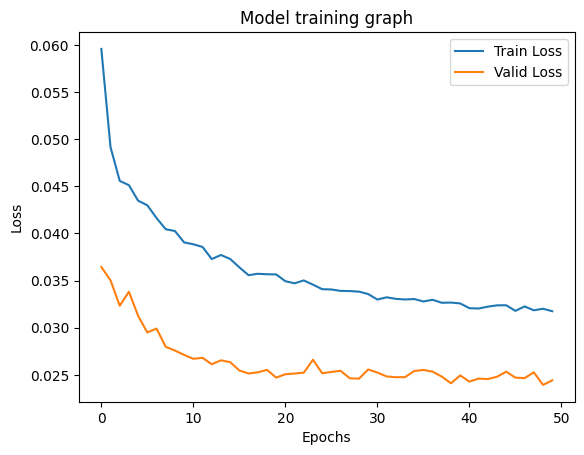

In [12]:
# plot the training graph
def plot_train_graph(train_loss_list, valid_loss_list):
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(valid_loss_list, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model training graph')
    plt.legend()
    plt.show()

plot_train_graph(train_loss_list, valid_loss_list)

In [13]:
import math

# get the best performing model weights
model.load_state_dict(torch.load('mlp.pt'))

def show_boulder(model, device, dataset):
    # grab a boulder from the validation set and see what the net thinks
    view_iterator = data.DataLoader(dataset,
                                     shuffle=True,
                                     batch_size=1)
    
    # set it up properly for viewing + prediction
    board, grade = next(iter(view_iterator))
    view_board = board.reshape(18, 11, 2)
    view_grade = grade.reshape(7)
    board = board.to(device)
    grade = grade.to(device)
    print_board(view_board, view_grade.numpy())
    pred = model.eval()(board)[0].cpu()
    pred_numpy = pred.detach().numpy().reshape(7)
    pred_sig_numpy = torch.sigmoid(pred).detach().numpy().reshape(7)
    rounded_pred = np.round(pred_sig_numpy, 1)
    thresholded_pred = tuple(1 if x > 0 else 0 for x in pred_numpy)
    print(f"NN Estimation: {list_to_grade[thresholded_pred]}")
    print(f"Full correct class: {view_grade.numpy()}")
    print(f"Model estim. class: {rounded_pred}")

show_boulder(model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - E - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - M - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - M - - - - 
13 | - - - - - - - - - - - 
12 | - - - - - M - - - - - 
11 | - - - - - - - - - - - 
10 | - - - - M - - - - - - 
 9 | - - - - - - M - - - - 
 8 | - - - - M - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - M - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)
NN Estimation: V5 (6C/+)
Full correct class: [0. 0. 0. 0. 0. 0. 0.]
Model estim. class: [0.6 0.2 0.1 0.  0.  0.  0. ]


In [14]:
def get_acc(y, y_pred):
    return sum([int(item == y_pred[idx]) for idx, item in enumerate(y)]) / len(y_pred)
        
def get_acc_plus_minus_one(y, y_pred):
    return sum([int(abs(item - y_pred[idx]) <= 1) for idx, item in enumerate(y)]) / len(y_pred)

# metrics generator for model
def get_metrics(model, iterator, device, thresholds=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]):

    ticklabels = ["V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11+"]

    model.eval()

    cf_pred = []
    cf_true = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Getting model metrics / generating report", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            # convert prediction vector into class
            for idx, item in enumerate(y_pred):
                true_y = y[idx]
                max_idx_pred = sum([int(F.sigmoid(x) > thresholds[i]) for i, x in enumerate(item)])
                max_idx_true = sum([int(x > 0) for i, x in enumerate(true_y)])
                cf_pred.append(max_idx_pred)
                cf_true.append(max_idx_true)

    print(f"Accuracy: {get_acc(cf_true, cf_pred):.2%} | Accuracy +- 1: {get_acc_plus_minus_one(cf_true, cf_pred):.2%}")
    print(classification_report(cf_true, cf_pred, target_names=ticklabels, digits=4))
    cf_matrix = confusion_matrix(cf_true, cf_pred)
    cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    ax = sns.heatmap(cf_matrix_norm, annot=True, fmt='.0%', xticklabels=ticklabels, yticklabels=ticklabels)
    ax.set(xlabel="Predicted Labels", ylabel="True Labels")
    plt.show()

Training set metrics:


Accuracy: 61.94% | Accuracy +- 1: 95.87%
              precision    recall  f1-score   support

          V4     0.8171    0.8022    0.8095      4671
          V5     0.5650    0.4832    0.5209      3183
          V6     0.3964    0.4450    0.4193      1454
          V7     0.3121    0.4988    0.3840       836
          V8     0.6119    0.4776    0.5365      1116
          V9     0.4437    0.7296    0.5518       270
         V10     0.9468    0.7036    0.8073       253
        V11+     0.9643    1.0000    0.9818       108

    accuracy                         0.6194     11891
   macro avg     0.6322    0.6425    0.6264     11891
weighted avg     0.6390    0.6194    0.6247     11891



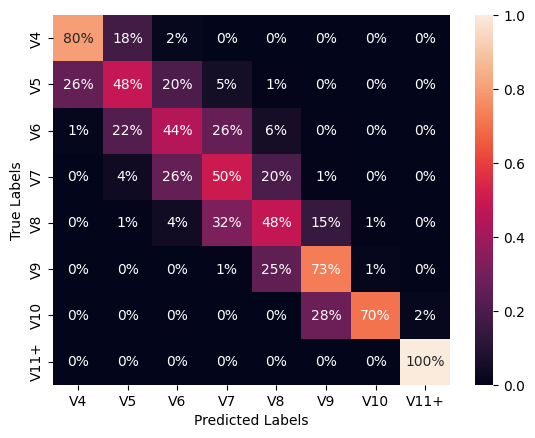

Validation set metrics:


Accuracy: 56.61% | Accuracy +- 1: 91.25%
              precision    recall  f1-score   support

          V4     0.8191    0.8112    0.8151      1557
          V5     0.5554    0.4769    0.5132      1061
          V6     0.3316    0.3897    0.3583       485
          V7     0.2574    0.3763    0.3057       279
          V8     0.4094    0.3280    0.3642       372
          V9     0.1769    0.2889    0.2194        90
         V10     0.3692    0.2857    0.3221        84
        V11+     0.3913    0.2500    0.3051        36

    accuracy                         0.5661      3964
   macro avg     0.4138    0.4008    0.4004      3964
weighted avg     0.5829    0.5661    0.5716      3964



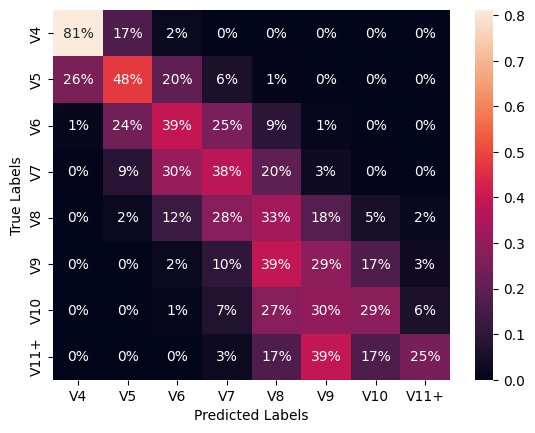

In [15]:
# get metrics
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)

valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(model, valid_cf_iter, device)

In [16]:
# now try training the CNN model and check the stats
cnn_model = CNN(n_channels, INPUT_DIM // n_channels, OUTPUT_DIM)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=5e-5)

cnn_model = cnn_model.to(device)
criterion = criterion.to(device)

train_loss_list, valid_loss_list = full_train_valid_loop(cnn_model, 'cnn', train_iterator, valid_iterator, criterion, device, label_smoothing = True)

Number of trainable parameters: 128,919


Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.05502 | Train Acc:  32.77% | Train Acc +/- 1 Grade:  66.04%
	 Val. Loss: 0.03431 |  Val. Acc:  49.09% |  Val. Acc +/- 1 Grade:  83.22%


Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.04119 | Train Acc:  41.13% | Train Acc +/- 1 Grade:  80.78%
	 Val. Loss: 0.03026 |  Val. Acc:  51.03% |  Val. Acc +/- 1 Grade:  87.12%


Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.03616 | Train Acc:  45.06% | Train Acc +/- 1 Grade:  85.36%
	 Val. Loss: 0.02603 |  Val. Acc:  55.19% |  Val. Acc +/- 1 Grade:  90.32%


Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.03318 | Train Acc:  47.74% | Train Acc +/- 1 Grade:  88.33%
	 Val. Loss: 0.02661 |  Val. Acc:  51.71% |  Val. Acc +/- 1 Grade:  90.70%


Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.03225 | Train Acc:  48.67% | Train Acc +/- 1 Grade:  88.77%
	 Val. Loss: 0.02466 |  Val. Acc:  54.84% |  Val. Acc +/- 1 Grade:  92.21%


Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.03121 | Train Acc:  49.24% | Train Acc +/- 1 Grade:  90.16%
	 Val. Loss: 0.02460 |  Val. Acc:  54.28% |  Val. Acc +/- 1 Grade:  91.00%


Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.03030 | Train Acc:  50.89% | Train Acc +/- 1 Grade:  90.96%
	 Val. Loss: 0.02486 |  Val. Acc:  52.75% |  Val. Acc +/- 1 Grade:  91.76%


Epoch: 08 | Epoch Time: 0m 5s
	Train Loss: 0.03000 | Train Acc:  51.40% | Train Acc +/- 1 Grade:  90.98%
	 Val. Loss: 0.02414 |  Val. Acc:  54.03% |  Val. Acc +/- 1 Grade:  91.61%


Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.02920 | Train Acc:  52.65% | Train Acc +/- 1 Grade:  92.01%
	 Val. Loss: 0.02314 |  Val. Acc:  55.29% |  Val. Acc +/- 1 Grade:  92.92%


Epoch: 10 | Epoch Time: 0m 5s
	Train Loss: 0.02888 | Train Acc:  52.82% | Train Acc +/- 1 Grade:  91.84%
	 Val. Loss: 0.02627 |  Val. Acc:  47.58% |  Val. Acc +/- 1 Grade:  90.40%


Epoch: 11 | Epoch Time: 0m 5s
	Train Loss: 0.02846 | Train Acc:  53.70% | Train Acc +/- 1 Grade:  92.31%
	 Val. Loss: 0.02443 |  Val. Acc:  53.07% |  Val. Acc +/- 1 Grade:  91.00%


Epoch: 12 | Epoch Time: 0m 5s
	Train Loss: 0.02808 | Train Acc:  54.84% | Train Acc +/- 1 Grade:  92.74%
	 Val. Loss: 0.02383 |  Val. Acc:  53.68% |  Val. Acc +/- 1 Grade:  91.61%


Epoch: 13 | Epoch Time: 0m 5s
	Train Loss: 0.02818 | Train Acc:  54.42% | Train Acc +/- 1 Grade:  92.59%
	 Val. Loss: 0.02346 |  Val. Acc:  55.42% |  Val. Acc +/- 1 Grade:  92.54%


Epoch: 14 | Epoch Time: 0m 5s
	Train Loss: 0.02807 | Train Acc:  54.42% | Train Acc +/- 1 Grade:  92.47%
	 Val. Loss: 0.02287 |  Val. Acc:  56.85% |  Val. Acc +/- 1 Grade:  92.89%


Epoch: 15 | Epoch Time: 0m 5s
	Train Loss: 0.02764 | Train Acc:  55.65% | Train Acc +/- 1 Grade:  92.87%
	 Val. Loss: 0.02389 |  Val. Acc:  53.40% |  Val. Acc +/- 1 Grade:  92.31%


Epoch: 16 | Epoch Time: 0m 5s
	Train Loss: 0.02743 | Train Acc:  54.69% | Train Acc +/- 1 Grade:  93.22%
	 Val. Loss: 0.02405 |  Val. Acc:  52.80% |  Val. Acc +/- 1 Grade:  92.11%


Epoch: 17 | Epoch Time: 0m 5s
	Train Loss: 0.02738 | Train Acc:  55.66% | Train Acc +/- 1 Grade:  93.33%
	 Val. Loss: 0.02264 |  Val. Acc:  57.38% |  Val. Acc +/- 1 Grade:  93.09%


Epoch: 18 | Epoch Time: 0m 5s
	Train Loss: 0.02706 | Train Acc:  55.96% | Train Acc +/- 1 Grade:  93.75%
	 Val. Loss: 0.02324 |  Val. Acc:  55.32% |  Val. Acc +/- 1 Grade:  92.87%


Epoch: 19 | Epoch Time: 0m 5s
	Train Loss: 0.02698 | Train Acc:  56.08% | Train Acc +/- 1 Grade:  93.62%
	 Val. Loss: 0.02254 |  Val. Acc:  56.10% |  Val. Acc +/- 1 Grade:  93.22%


Epoch: 20 | Epoch Time: 0m 5s
	Train Loss: 0.02677 | Train Acc:  56.06% | Train Acc +/- 1 Grade:  94.08%
	 Val. Loss: 0.02265 |  Val. Acc:  55.65% |  Val. Acc +/- 1 Grade:  92.64%


Epoch: 21 | Epoch Time: 0m 5s
	Train Loss: 0.02680 | Train Acc:  56.47% | Train Acc +/- 1 Grade:  93.69%
	 Val. Loss: 0.02258 |  Val. Acc:  57.46% |  Val. Acc +/- 1 Grade:  93.12%


Epoch: 22 | Epoch Time: 0m 5s
	Train Loss: 0.02649 | Train Acc:  56.94% | Train Acc +/- 1 Grade:  94.01%
	 Val. Loss: 0.02389 |  Val. Acc:  52.72% |  Val. Acc +/- 1 Grade:  92.94%


Epoch: 23 | Epoch Time: 0m 5s
	Train Loss: 0.02670 | Train Acc:  56.46% | Train Acc +/- 1 Grade:  93.83%
	 Val. Loss: 0.02396 |  Val. Acc:  53.50% |  Val. Acc +/- 1 Grade:  92.34%


Epoch: 24 | Epoch Time: 0m 5s
	Train Loss: 0.02681 | Train Acc:  56.61% | Train Acc +/- 1 Grade:  93.88%
	 Val. Loss: 0.02439 |  Val. Acc:  51.71% |  Val. Acc +/- 1 Grade:  92.19%


Epoch: 25 | Epoch Time: 0m 5s
	Train Loss: 0.02638 | Train Acc:  57.49% | Train Acc +/- 1 Grade:  93.91%
	 Val. Loss: 0.02254 |  Val. Acc:  57.41% |  Val. Acc +/- 1 Grade:  92.59%


Epoch: 26 | Epoch Time: 0m 5s
	Train Loss: 0.02637 | Train Acc:  57.32% | Train Acc +/- 1 Grade:  93.99%
	 Val. Loss: 0.02277 |  Val. Acc:  56.48% |  Val. Acc +/- 1 Grade:  92.77%


Epoch: 27 | Epoch Time: 0m 6s
	Train Loss: 0.02635 | Train Acc:  57.06% | Train Acc +/- 1 Grade:  94.36%
	 Val. Loss: 0.02239 |  Val. Acc:  57.43% |  Val. Acc +/- 1 Grade:  93.20%


Epoch: 28 | Epoch Time: 0m 5s
	Train Loss: 0.02629 | Train Acc:  57.48% | Train Acc +/- 1 Grade:  94.33%
	 Val. Loss: 0.02405 |  Val. Acc:  51.92% |  Val. Acc +/- 1 Grade:  91.91%


Epoch: 29 | Epoch Time: 0m 5s
	Train Loss: 0.02619 | Train Acc:  56.96% | Train Acc +/- 1 Grade:  94.17%
	 Val. Loss: 0.02276 |  Val. Acc:  55.80% |  Val. Acc +/- 1 Grade:  92.92%


Epoch: 30 | Epoch Time: 0m 5s
	Train Loss: 0.02640 | Train Acc:  57.14% | Train Acc +/- 1 Grade:  94.17%
	 Val. Loss: 0.02236 |  Val. Acc:  56.12% |  Val. Acc +/- 1 Grade:  92.99%


Epoch: 31 | Epoch Time: 0m 5s
	Train Loss: 0.02668 | Train Acc:  57.50% | Train Acc +/- 1 Grade:  94.07%
	 Val. Loss: 0.02375 |  Val. Acc:  53.33% |  Val. Acc +/- 1 Grade:  92.54%


Epoch: 32 | Epoch Time: 0m 5s
	Train Loss: 0.02650 | Train Acc:  56.69% | Train Acc +/- 1 Grade:  94.33%
	 Val. Loss: 0.02277 |  Val. Acc:  56.28% |  Val. Acc +/- 1 Grade:  92.67%


Epoch: 33 | Epoch Time: 0m 5s
	Train Loss: 0.02644 | Train Acc:  57.15% | Train Acc +/- 1 Grade:  94.36%
	 Val. Loss: 0.02292 |  Val. Acc:  55.47% |  Val. Acc +/- 1 Grade:  93.17%


Epoch: 34 | Epoch Time: 0m 5s
	Train Loss: 0.02609 | Train Acc:  57.92% | Train Acc +/- 1 Grade:  94.45%
	 Val. Loss: 0.02255 |  Val. Acc:  56.22% |  Val. Acc +/- 1 Grade:  93.12%


Epoch: 35 | Epoch Time: 0m 5s
	Train Loss: 0.02598 | Train Acc:  57.39% | Train Acc +/- 1 Grade:  94.62%
	 Val. Loss: 0.02443 |  Val. Acc:  51.51% |  Val. Acc +/- 1 Grade:  90.95%


Epoch: 36 | Epoch Time: 0m 6s
	Train Loss: 0.02612 | Train Acc:  57.56% | Train Acc +/- 1 Grade:  94.28%
	 Val. Loss: 0.02358 |  Val. Acc:  53.10% |  Val. Acc +/- 1 Grade:  92.87%


Epoch: 37 | Epoch Time: 0m 6s
	Train Loss: 0.02567 | Train Acc:  58.49% | Train Acc +/- 1 Grade:  94.45%
	 Val. Loss: 0.02313 |  Val. Acc:  55.07% |  Val. Acc +/- 1 Grade:  92.41%


Epoch: 38 | Epoch Time: 0m 6s
	Train Loss: 0.02587 | Train Acc:  58.53% | Train Acc +/- 1 Grade:  94.59%
	 Val. Loss: 0.02420 |  Val. Acc:  51.39% |  Val. Acc +/- 1 Grade:  91.81%


Epoch: 39 | Epoch Time: 0m 6s
	Train Loss: 0.02570 | Train Acc:  58.78% | Train Acc +/- 1 Grade:  94.82%
	 Val. Loss: 0.02275 |  Val. Acc:  56.25% |  Val. Acc +/- 1 Grade:  93.09%


Epoch: 40 | Epoch Time: 0m 5s
	Train Loss: 0.02615 | Train Acc:  57.78% | Train Acc +/- 1 Grade:  94.46%
	 Val. Loss: 0.02245 |  Val. Acc:  56.78% |  Val. Acc +/- 1 Grade:  93.32%


Epoch: 41 | Epoch Time: 0m 5s
	Train Loss: 0.02534 | Train Acc:  59.17% | Train Acc +/- 1 Grade:  95.26%
	 Val. Loss: 0.02253 |  Val. Acc:  57.59% |  Val. Acc +/- 1 Grade:  92.26%


Epoch: 42 | Epoch Time: 0m 5s
	Train Loss: 0.02605 | Train Acc:  58.31% | Train Acc +/- 1 Grade:  94.70%
	 Val. Loss: 0.02287 |  Val. Acc:  54.91% |  Val. Acc +/- 1 Grade:  92.84%


Epoch: 43 | Epoch Time: 0m 6s
	Train Loss: 0.02596 | Train Acc:  57.52% | Train Acc +/- 1 Grade:  94.54%
	 Val. Loss: 0.02241 |  Val. Acc:  57.18% |  Val. Acc +/- 1 Grade:  93.07%


Epoch: 44 | Epoch Time: 0m 6s
	Train Loss: 0.02578 | Train Acc:  58.72% | Train Acc +/- 1 Grade:  94.77%
	 Val. Loss: 0.02419 |  Val. Acc:  51.08% |  Val. Acc +/- 1 Grade:  92.82%


Epoch: 45 | Epoch Time: 0m 6s
	Train Loss: 0.02567 | Train Acc:  58.87% | Train Acc +/- 1 Grade:  94.86%
	 Val. Loss: 0.02312 |  Val. Acc:  55.07% |  Val. Acc +/- 1 Grade:  92.92%


Epoch: 46 | Epoch Time: 0m 7s
	Train Loss: 0.02572 | Train Acc:  58.83% | Train Acc +/- 1 Grade:  94.68%
	 Val. Loss: 0.02243 |  Val. Acc:  57.26% |  Val. Acc +/- 1 Grade:  93.22%


Epoch: 47 | Epoch Time: 0m 5s
	Train Loss: 0.02553 | Train Acc:  58.62% | Train Acc +/- 1 Grade:  94.97%
	 Val. Loss: 0.02264 |  Val. Acc:  56.00% |  Val. Acc +/- 1 Grade:  93.32%


Epoch: 48 | Epoch Time: 0m 5s
	Train Loss: 0.02552 | Train Acc:  59.10% | Train Acc +/- 1 Grade:  94.79%
	 Val. Loss: 0.02416 |  Val. Acc:  51.36% |  Val. Acc +/- 1 Grade:  92.57%


Epoch: 49 | Epoch Time: 0m 5s
	Train Loss: 0.02538 | Train Acc:  59.02% | Train Acc +/- 1 Grade:  95.19%
	 Val. Loss: 0.02247 |  Val. Acc:  56.10% |  Val. Acc +/- 1 Grade:  93.30%


Epoch: 50 | Epoch Time: 0m 5s
	Train Loss: 0.02586 | Train Acc:  57.74% | Train Acc +/- 1 Grade:  94.45%
	 Val. Loss: 0.02259 |  Val. Acc:  55.95% |  Val. Acc +/- 1 Grade:  93.40%


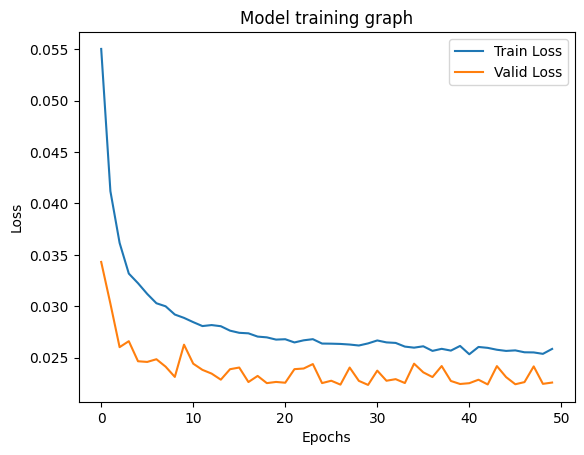

In [17]:
# plot our graph
plot_train_graph(train_loss_list, valid_loss_list)

In [18]:
# get the best performing model weights
cnn_model.load_state_dict(torch.load('cnn.pt'))

# show a boulder
show_boulder(cnn_model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - - - - - E - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - - - - - M - - 
14 | - - - - M - - - - - - 
13 | - - - - - - - - - - - 
12 | - - - - M - - - - - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - M - - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - - - - - - - 
 4 | - - - - - - S - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V8 (7B/+)
NN Estimation: V7 (7A+)
Full correct class: [1. 1. 1. 1. 0. 0. 0.]
Model estim. class: [1.  0.9 0.8 0.4 0.1 0.  0. ]


Training set metrics:


Accuracy: 65.77% | Accuracy +- 1: 97.48%
              precision    recall  f1-score   support

          V4     0.8518    0.7701    0.8089      4671
          V5     0.5795    0.5715    0.5755      3183
          V6     0.4412    0.4746    0.4573      1454
          V7     0.3703    0.6878    0.4814       836
          V8     0.8282    0.5099    0.6312      1116
          V9     0.6334    0.8704    0.7332       270
         V10     0.9306    0.9012    0.9157       253
        V11+     0.9908    1.0000    0.9954       108

    accuracy                         0.6577     11891
   macro avg     0.7032    0.7232    0.6998     11891
weighted avg     0.6906    0.6577    0.6659     11891



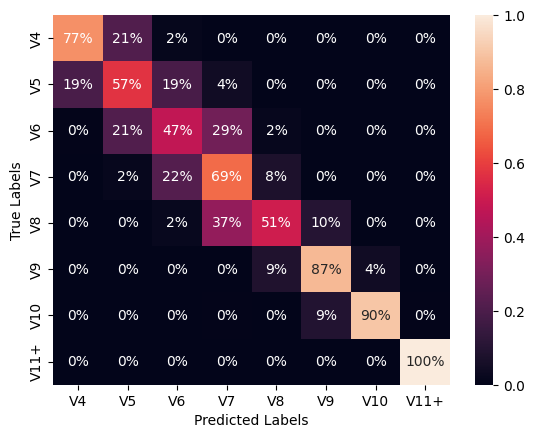

Validation set metrics:


Accuracy: 56.10% | Accuracy +- 1: 93.01%
              precision    recall  f1-score   support

          V4     0.8357    0.7611    0.7966      1557
          V5     0.5289    0.5080    0.5183      1061
          V6     0.3388    0.4268    0.3777       485
          V7     0.2414    0.4014    0.3015       279
          V8     0.5042    0.3253    0.3954       372
          V9     0.2237    0.3778    0.2810        90
         V10     0.3725    0.2262    0.2815        84
        V11+     0.7778    0.1944    0.3111        36

    accuracy                         0.5610      3964
   macro avg     0.4779    0.4026    0.4079      3964
weighted avg     0.5956    0.5610    0.5713      3964



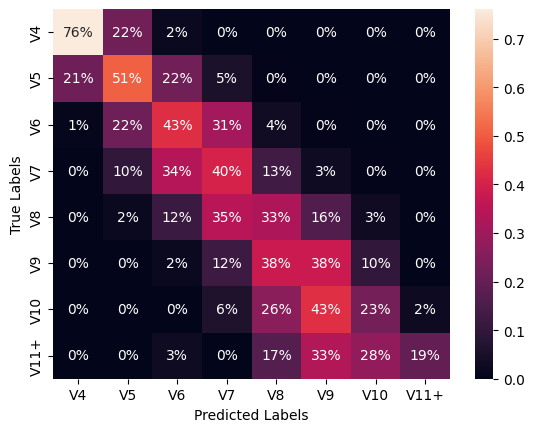

In [19]:
# get model stats
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)


valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(cnn_model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(cnn_model, valid_cf_iter, device)

In [20]:
# now try training the ResNet model and check the stats
resnet_model = ResNet(n_channels, INPUT_DIM // n_channels, OUTPUT_DIM)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=avg_class_difficulty)
optimizer = optim.Adam(resnet_model.parameters(), lr=1e-3, weight_decay=1e-4)

resnet_model = resnet_model.to(device)
criterion = criterion.to(device)

train_loss_list, valid_loss_list = full_train_valid_loop(resnet_model, 'resnet', train_iterator, valid_iterator, criterion, device, label_smoothing = True)

Number of trainable parameters: 151,047


Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 0.05684 | Train Acc:  31.65% | Train Acc +/- 1 Grade:  64.36%
	 Val. Loss: 0.03974 |  Val. Acc:  45.41% |  Val. Acc +/- 1 Grade:  76.79%


Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.04597 | Train Acc:  36.84% | Train Acc +/- 1 Grade:  74.33%
	 Val. Loss: 0.03171 |  Val. Acc:  50.55% |  Val. Acc +/- 1 Grade:  85.16%


Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.04048 | Train Acc:  39.95% | Train Acc +/- 1 Grade:  80.60%
	 Val. Loss: 0.02699 |  Val. Acc:  54.11% |  Val. Acc +/- 1 Grade:  88.68%


Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.03774 | Train Acc:  43.16% | Train Acc +/- 1 Grade:  83.65%
	 Val. Loss: 0.03164 |  Val. Acc:  48.61% |  Val. Acc +/- 1 Grade:  81.07%


Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.03842 | Train Acc:  41.68% | Train Acc +/- 1 Grade:  82.52%
	 Val. Loss: 0.02648 |  Val. Acc:  53.63% |  Val. Acc +/- 1 Grade:  88.10%


Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 0.03531 | Train Acc:  44.57% | Train Acc +/- 1 Grade:  85.55%
	 Val. Loss: 0.02524 |  Val. Acc:  54.36% |  Val. Acc +/- 1 Grade:  89.94%


Epoch: 07 | Epoch Time: 0m 8s
	Train Loss: 0.03412 | Train Acc:  46.14% | Train Acc +/- 1 Grade:  86.30%
	 Val. Loss: 0.02412 |  Val. Acc:  56.38% |  Val. Acc +/- 1 Grade:  91.08%


Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 0.03208 | Train Acc:  48.02% | Train Acc +/- 1 Grade:  88.66%
	 Val. Loss: 0.02431 |  Val. Acc:  55.32% |  Val. Acc +/- 1 Grade:  91.10%


Epoch: 09 | Epoch Time: 0m 8s
	Train Loss: 0.03168 | Train Acc:  48.46% | Train Acc +/- 1 Grade:  89.05%
	 Val. Loss: 0.02325 |  Val. Acc:  57.03% |  Val. Acc +/- 1 Grade:  91.91%


Epoch: 10 | Epoch Time: 0m 8s
	Train Loss: 0.03095 | Train Acc:  50.47% | Train Acc +/- 1 Grade:  89.96%
	 Val. Loss: 0.02415 |  Val. Acc:  56.65% |  Val. Acc +/- 1 Grade:  90.37%


Epoch: 11 | Epoch Time: 0m 8s
	Train Loss: 0.03095 | Train Acc:  50.26% | Train Acc +/- 1 Grade:  89.79%
	 Val. Loss: 0.02304 |  Val. Acc:  57.43% |  Val. Acc +/- 1 Grade:  92.01%


Epoch: 12 | Epoch Time: 0m 8s
	Train Loss: 0.03031 | Train Acc:  51.82% | Train Acc +/- 1 Grade:  90.32%
	 Val. Loss: 0.02381 |  Val. Acc:  55.14% |  Val. Acc +/- 1 Grade:  91.13%


Epoch: 13 | Epoch Time: 0m 7s
	Train Loss: 0.02937 | Train Acc:  52.75% | Train Acc +/- 1 Grade:  91.25%
	 Val. Loss: 0.02443 |  Val. Acc:  54.13% |  Val. Acc +/- 1 Grade:  90.30%


Epoch: 14 | Epoch Time: 0m 8s
	Train Loss: 0.02964 | Train Acc:  51.80% | Train Acc +/- 1 Grade:  91.32%
	 Val. Loss: 0.02271 |  Val. Acc:  57.64% |  Val. Acc +/- 1 Grade:  92.24%


Epoch: 15 | Epoch Time: 0m 8s
	Train Loss: 0.02918 | Train Acc:  52.60% | Train Acc +/- 1 Grade:  91.32%
	 Val. Loss: 0.02270 |  Val. Acc:  57.94% |  Val. Acc +/- 1 Grade:  91.58%


Epoch: 16 | Epoch Time: 0m 7s
	Train Loss: 0.02905 | Train Acc:  52.54% | Train Acc +/- 1 Grade:  91.87%
	 Val. Loss: 0.02256 |  Val. Acc:  57.33% |  Val. Acc +/- 1 Grade:  91.78%


Epoch: 17 | Epoch Time: 0m 8s
	Train Loss: 0.02851 | Train Acc:  54.62% | Train Acc +/- 1 Grade:  92.18%
	 Val. Loss: 0.02243 |  Val. Acc:  56.91% |  Val. Acc +/- 1 Grade:  92.01%


Epoch: 18 | Epoch Time: 0m 8s
	Train Loss: 0.02864 | Train Acc:  53.27% | Train Acc +/- 1 Grade:  92.31%
	 Val. Loss: 0.02261 |  Val. Acc:  57.89% |  Val. Acc +/- 1 Grade:  92.36%


Epoch: 19 | Epoch Time: 0m 8s
	Train Loss: 0.02813 | Train Acc:  53.76% | Train Acc +/- 1 Grade:  92.73%
	 Val. Loss: 0.02301 |  Val. Acc:  58.04% |  Val. Acc +/- 1 Grade:  91.73%


Epoch: 20 | Epoch Time: 0m 8s
	Train Loss: 0.02777 | Train Acc:  54.39% | Train Acc +/- 1 Grade:  93.26%
	 Val. Loss: 0.02232 |  Val. Acc:  57.38% |  Val. Acc +/- 1 Grade:  92.46%


Epoch: 21 | Epoch Time: 0m 7s
	Train Loss: 0.02791 | Train Acc:  53.99% | Train Acc +/- 1 Grade:  92.70%
	 Val. Loss: 0.02235 |  Val. Acc:  58.06% |  Val. Acc +/- 1 Grade:  92.01%


Epoch: 22 | Epoch Time: 0m 8s
	Train Loss: 0.02831 | Train Acc:  53.77% | Train Acc +/- 1 Grade:  92.64%
	 Val. Loss: 0.02256 |  Val. Acc:  57.31% |  Val. Acc +/- 1 Grade:  92.64%


Epoch: 23 | Epoch Time: 0m 8s
	Train Loss: 0.02758 | Train Acc:  54.90% | Train Acc +/- 1 Grade:  93.16%
	 Val. Loss: 0.02273 |  Val. Acc:  58.19% |  Val. Acc +/- 1 Grade:  91.56%


Epoch: 24 | Epoch Time: 0m 8s
	Train Loss: 0.02715 | Train Acc:  55.88% | Train Acc +/- 1 Grade:  93.73%
	 Val. Loss: 0.02228 |  Val. Acc:  58.95% |  Val. Acc +/- 1 Grade:  92.49%


Epoch: 25 | Epoch Time: 0m 8s
	Train Loss: 0.02762 | Train Acc:  54.82% | Train Acc +/- 1 Grade:  93.17%
	 Val. Loss: 0.02200 |  Val. Acc:  58.37% |  Val. Acc +/- 1 Grade:  92.34%


Epoch: 26 | Epoch Time: 0m 8s
	Train Loss: 0.02760 | Train Acc:  55.77% | Train Acc +/- 1 Grade:  93.13%
	 Val. Loss: 0.02187 |  Val. Acc:  58.90% |  Val. Acc +/- 1 Grade:  92.39%


Epoch: 27 | Epoch Time: 0m 8s
	Train Loss: 0.02701 | Train Acc:  55.46% | Train Acc +/- 1 Grade:  93.74%
	 Val. Loss: 0.02155 |  Val. Acc:  59.10% |  Val. Acc +/- 1 Grade:  92.94%


Epoch: 28 | Epoch Time: 0m 8s
	Train Loss: 0.02757 | Train Acc:  54.64% | Train Acc +/- 1 Grade:  93.13%
	 Val. Loss: 0.02228 |  Val. Acc:  58.37% |  Val. Acc +/- 1 Grade:  92.64%


Epoch: 29 | Epoch Time: 0m 8s
	Train Loss: 0.02729 | Train Acc:  56.18% | Train Acc +/- 1 Grade:  93.61%
	 Val. Loss: 0.02192 |  Val. Acc:  59.48% |  Val. Acc +/- 1 Grade:  92.62%


Epoch: 30 | Epoch Time: 0m 7s
	Train Loss: 0.02673 | Train Acc:  56.11% | Train Acc +/- 1 Grade:  93.92%
	 Val. Loss: 0.02306 |  Val. Acc:  57.71% |  Val. Acc +/- 1 Grade:  91.91%


Epoch: 31 | Epoch Time: 0m 8s
	Train Loss: 0.02731 | Train Acc:  55.82% | Train Acc +/- 1 Grade:  93.13%
	 Val. Loss: 0.02243 |  Val. Acc:  58.17% |  Val. Acc +/- 1 Grade:  92.19%


Epoch: 32 | Epoch Time: 0m 8s
	Train Loss: 0.02660 | Train Acc:  56.92% | Train Acc +/- 1 Grade:  93.90%
	 Val. Loss: 0.02265 |  Val. Acc:  57.59% |  Val. Acc +/- 1 Grade:  92.46%


Epoch: 33 | Epoch Time: 0m 8s
	Train Loss: 0.02680 | Train Acc:  56.46% | Train Acc +/- 1 Grade:  93.93%
	 Val. Loss: 0.02203 |  Val. Acc:  58.27% |  Val. Acc +/- 1 Grade:  92.01%


Epoch: 34 | Epoch Time: 0m 8s
	Train Loss: 0.02661 | Train Acc:  56.62% | Train Acc +/- 1 Grade:  94.14%
	 Val. Loss: 0.02171 |  Val. Acc:  59.38% |  Val. Acc +/- 1 Grade:  92.41%


Epoch: 35 | Epoch Time: 0m 8s
	Train Loss: 0.02670 | Train Acc:  56.55% | Train Acc +/- 1 Grade:  93.95%
	 Val. Loss: 0.02218 |  Val. Acc:  57.74% |  Val. Acc +/- 1 Grade:  91.78%


Epoch: 36 | Epoch Time: 0m 8s
	Train Loss: 0.02632 | Train Acc:  56.57% | Train Acc +/- 1 Grade:  94.55%
	 Val. Loss: 0.02320 |  Val. Acc:  56.53% |  Val. Acc +/- 1 Grade:  91.89%


Epoch: 37 | Epoch Time: 0m 8s
	Train Loss: 0.02703 | Train Acc:  56.15% | Train Acc +/- 1 Grade:  93.73%
	 Val. Loss: 0.02307 |  Val. Acc:  56.53% |  Val. Acc +/- 1 Grade:  91.68%


Epoch: 38 | Epoch Time: 0m 8s
	Train Loss: 0.02623 | Train Acc:  57.85% | Train Acc +/- 1 Grade:  94.02%
	 Val. Loss: 0.02200 |  Val. Acc:  58.64% |  Val. Acc +/- 1 Grade:  92.06%


Epoch: 39 | Epoch Time: 0m 8s
	Train Loss: 0.02671 | Train Acc:  57.06% | Train Acc +/- 1 Grade:  94.16%
	 Val. Loss: 0.02202 |  Val. Acc:  57.84% |  Val. Acc +/- 1 Grade:  93.32%


Epoch: 40 | Epoch Time: 0m 8s
	Train Loss: 0.02648 | Train Acc:  56.74% | Train Acc +/- 1 Grade:  94.57%
	 Val. Loss: 0.02217 |  Val. Acc:  58.39% |  Val. Acc +/- 1 Grade:  92.62%


Epoch: 41 | Epoch Time: 0m 8s
	Train Loss: 0.02620 | Train Acc:  57.52% | Train Acc +/- 1 Grade:  94.50%
	 Val. Loss: 0.02237 |  Val. Acc:  57.79% |  Val. Acc +/- 1 Grade:  91.81%


Epoch: 42 | Epoch Time: 0m 8s
	Train Loss: 0.02662 | Train Acc:  56.68% | Train Acc +/- 1 Grade:  94.33%
	 Val. Loss: 0.02232 |  Val. Acc:  58.11% |  Val. Acc +/- 1 Grade:  92.09%


Epoch: 43 | Epoch Time: 0m 8s
	Train Loss: 0.02604 | Train Acc:  57.99% | Train Acc +/- 1 Grade:  94.40%
	 Val. Loss: 0.02206 |  Val. Acc:  58.87% |  Val. Acc +/- 1 Grade:  92.49%


Epoch: 44 | Epoch Time: 0m 8s
	Train Loss: 0.02616 | Train Acc:  56.99% | Train Acc +/- 1 Grade:  94.46%
	 Val. Loss: 0.02217 |  Val. Acc:  58.87% |  Val. Acc +/- 1 Grade:  92.36%


Epoch: 45 | Epoch Time: 0m 8s
	Train Loss: 0.02588 | Train Acc:  58.10% | Train Acc +/- 1 Grade:  94.85%
	 Val. Loss: 0.02441 |  Val. Acc:  53.12% |  Val. Acc +/- 1 Grade:  90.80%


Epoch: 46 | Epoch Time: 0m 8s
	Train Loss: 0.02624 | Train Acc:  57.25% | Train Acc +/- 1 Grade:  94.17%
	 Val. Loss: 0.02172 |  Val. Acc:  59.38% |  Val. Acc +/- 1 Grade:  92.67%


Epoch: 47 | Epoch Time: 0m 8s
	Train Loss: 0.02637 | Train Acc:  57.75% | Train Acc +/- 1 Grade:  94.61%
	 Val. Loss: 0.02223 |  Val. Acc:  58.67% |  Val. Acc +/- 1 Grade:  92.52%


Epoch: 48 | Epoch Time: 0m 8s
	Train Loss: 0.02620 | Train Acc:  58.17% | Train Acc +/- 1 Grade:  94.21%
	 Val. Loss: 0.02174 |  Val. Acc:  58.49% |  Val. Acc +/- 1 Grade:  92.77%


Epoch: 49 | Epoch Time: 0m 8s
	Train Loss: 0.02566 | Train Acc:  59.41% | Train Acc +/- 1 Grade:  94.83%
	 Val. Loss: 0.02290 |  Val. Acc:  57.74% |  Val. Acc +/- 1 Grade:  91.91%


Epoch: 50 | Epoch Time: 0m 8s
	Train Loss: 0.02566 | Train Acc:  58.93% | Train Acc +/- 1 Grade:  94.71%
	 Val. Loss: 0.02371 |  Val. Acc:  56.30% |  Val. Acc +/- 1 Grade:  91.66%


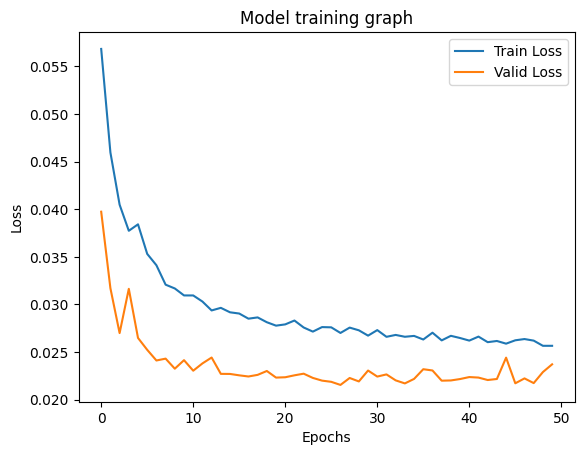

In [21]:
# plot our graph
plot_train_graph(train_loss_list, valid_loss_list)

In [22]:
# get the best performing model weights
resnet_model.load_state_dict(torch.load('resnet.pt'))

# show a boulder
show_boulder(resnet_model, device, val_dataset)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - - - - - E - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - M - - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - - - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - - - - 
10 | - - - - - M - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - M - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - S - - - - 
 5 | - - - - - - - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - S - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V10 (7C+)
NN Estimation: V9 (7C)
Full correct class: [1. 1. 1. 1. 1. 1. 0.]
Model estim. class: [1.  1.  1.  0.9 0.8 0.4 0. ]


Training set metrics:


Accuracy: 64.36% | Accuracy +- 1: 96.75%
              precision    recall  f1-score   support

          V4     0.7739    0.8925    0.8290      4671
          V5     0.5974    0.4703    0.5263      3183
          V6     0.4356    0.4746    0.4542      1454
          V7     0.3320    0.3959    0.3612       836
          V8     0.7127    0.3934    0.5069      1116
          V9     0.5149    0.7667    0.6161       270
         V10     0.8123    0.8379    0.8249       253
        V11+     0.7826    1.0000    0.8780       108

    accuracy                         0.6436     11891
   macro avg     0.6202    0.6539    0.6246     11891
weighted avg     0.6435    0.6436    0.6345     11891



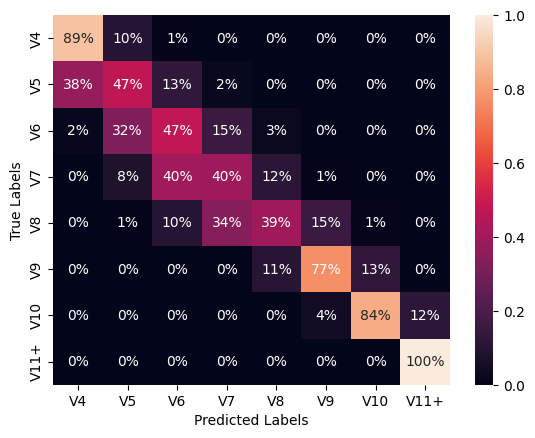

Validation set metrics:


Accuracy: 59.08% | Accuracy +- 1: 92.94%
              precision    recall  f1-score   support

          V4     0.7763    0.8895    0.8291      1557
          V5     0.5584    0.4505    0.4987      1061
          V6     0.3682    0.4206    0.3927       485
          V7     0.2804    0.2975    0.2887       279
          V8     0.5165    0.3360    0.4072       372
          V9     0.2240    0.3111    0.2605        90
         V10     0.3218    0.3333    0.3275        84
        V11+     0.5500    0.3056    0.3929        36

    accuracy                         0.5908      3964
   macro avg     0.4495    0.4180    0.4246      3964
weighted avg     0.5846    0.5908    0.5821      3964



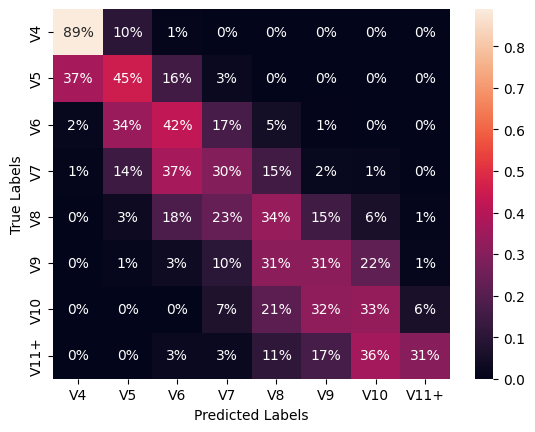

In [23]:
# get model stats
train_cf_iter = data.DataLoader(train_dataset,
                                 shuffle=False,
                                 batch_size=64)


valid_cf_iter = data.DataLoader(val_dataset,
                                 shuffle=False,
                                 batch_size=64)

print(f"Training set metrics:")
get_metrics(resnet_model, train_cf_iter, device)
print(f"Validation set metrics:")
get_metrics(resnet_model, valid_cf_iter, device)

Test set metrics:
---- MLP ----


Accuracy: 55.88% | Accuracy +- 1: 91.27%
              precision    recall  f1-score   support

          V4     0.8160    0.8144    0.8152      1557
          V5     0.5274    0.4543    0.4881      1061
          V6     0.3035    0.3423    0.3217       485
          V7     0.2128    0.2975    0.2481       279
          V8     0.4572    0.4167    0.4360       372
          V9     0.2500    0.4111    0.3109        90
         V10     0.2708    0.1548    0.1970        84
        V11+     0.4583    0.3056    0.3667        36

    accuracy                         0.5588      3964
   macro avg     0.4120    0.3996    0.3980      3964
weighted avg     0.5722    0.5588    0.5631      3964



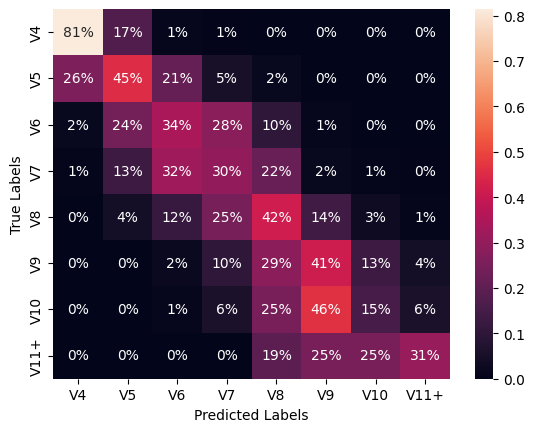

---- CNN ----


Accuracy: 56.05% | Accuracy +- 1: 92.13%
              precision    recall  f1-score   support

          V4     0.8474    0.7848    0.8149      1557
          V5     0.5292    0.4863    0.5069      1061
          V6     0.3172    0.4062    0.3562       485
          V7     0.2251    0.3799    0.2827       279
          V8     0.4855    0.3145    0.3817       372
          V9     0.2766    0.4333    0.3377        90
         V10     0.3000    0.2143    0.2500        84
        V11+     0.5385    0.1944    0.2857        36

    accuracy                         0.5605      3964
   macro avg     0.4399    0.4017    0.4020      3964
weighted avg     0.5923    0.5605    0.5706      3964



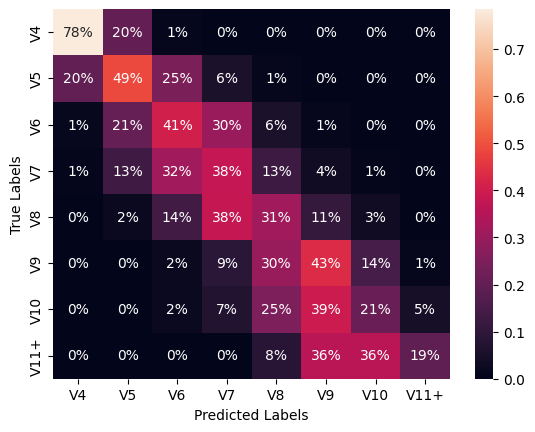

-- ResNet ---


Accuracy: 58.60% | Accuracy +- 1: 91.30%
              precision    recall  f1-score   support

          V4     0.7722    0.8927    0.8281      1557
          V5     0.5695    0.4477    0.5013      1061
          V6     0.3724    0.4124    0.3914       485
          V7     0.2646    0.3082    0.2848       279
          V8     0.4741    0.2957    0.3642       372
          V9     0.2098    0.3333    0.2575        90
         V10     0.3151    0.2738    0.2930        84
        V11+     0.4500    0.2500    0.3214        36

    accuracy                         0.5860      3964
   macro avg     0.4285    0.4017    0.4052      3964
weighted avg     0.5800    0.5860    0.5765      3964



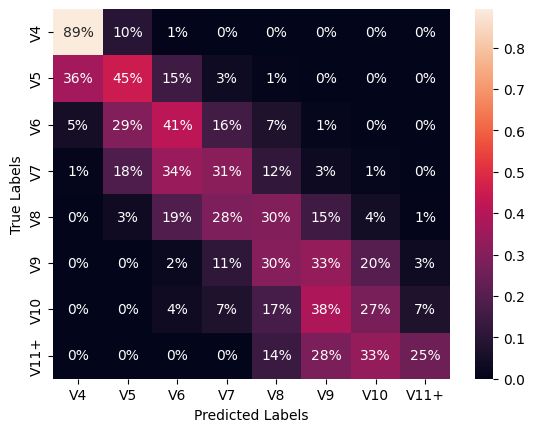

In [24]:
# Finally, we check all of the models' performance on the test dataset
test_cf_iter = data.DataLoader(test_dataset,
                                 shuffle=False,
                                 batch_size=64)


print(f"Test set metrics:")
print(f"---- MLP ----")
get_metrics(model, test_cf_iter, device)
print(f"---- CNN ----")
get_metrics(cnn_model, test_cf_iter, device)
print(f"-- ResNet ---")
get_metrics(resnet_model, test_cf_iter, device)

In [25]:
# save using onnx runtime for inference (only available for MLP since the CNN and the ResNet both use adaptive Max-Pooling)
view_iterator = data.DataLoader(dataset,
                                     shuffle=True,
                                     batch_size=1)

board, grade = next(iter(view_iterator))
model = model.to(device)
board = board.to(device)
torch.onnx.export(model,                     # model being run
                  board,                     # model input (or a tuple for multiple inputs)
                  "moonboard-clf-mlp.onnx",  # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                            # the ONNX version to export the model to
                    # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [26]:
# save the other models for inference
torch.save(cnn_model, 'moonboard-clf-cnn.pth')
torch.save(resnet_model, 'moonboard-clf-resnet.pth')